We're just looking for interesting observations regarding our data set :)

Let's start with imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Let's continue loading the dataset

In [2]:
df = pd.read_csv("feature_data.csv", index_col=0)
labels = pd.read_csv("label_data.csv", index_col=0)
merged_df = df.merge(labels, right_index=True, left_index=True)

Now, let's see which features are we working with

In [3]:
print(f"Our dataset size is: {df.shape}")
df.head(1)

Our dataset size is: (89542, 33)


,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,order_type,...,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13
51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,Offline TA/TO,...,0,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0


Let's see each column's type

In [4]:
print("\n".join([f"{col}: {df[col].dtype}" for col in df.columns]))

time_until_order: float64
order_year: int64
order_month: object
order_week: object
order_day_of_month: int64
adults: int64
children: float64
babies: int64
country: object
order_type: object
acquisition_channel: object
prev_canceled: int64
prev_not_canceled: int64
changes: float64
deposit_type: object
agent: float64
company: float64
customer_type: object
adr: float64
anon_feat_0: float64
anon_feat_1: int64
anon_feat_2: int64
anon_feat_3: int64
anon_feat_4: int64
anon_feat_5: float64
anon_feat_6: float64
anon_feat_7: float64
anon_feat_8: int64
anon_feat_9: float64
anon_feat_10: float64
anon_feat_11: float64
anon_feat_12: bool
anon_feat_13: float64


We can start by changing anon_feat_12 from 'bool' to 'int64' to make it easier for us to handle.
Let's see how many empty values it has.

In [5]:
df[df["anon_feat_12"].isna()].shape

(0, 33)

It looks like there are no samples that have a null value for this variable - so we can convert the column safely.

In [6]:
df["anon_feat_12"] = [int(value) for value in df["anon_feat_12"]]

Before we move on to the next stage of exploration, let's divide the columns based on their values:

In [7]:
categorical_cols = [col_name for col_name in df.columns if df[col_name].dtype == np.object]
numerical_cols = [col_name for col_name in df.columns if df[col_name].dtype in (np.int64, np.float64)]

Let's try and see which categorical features we're working with:
<br>
Here's a list of each categorical feature (seen by pandas as type 'O'), and the number of unique features it has

In [8]:
[(col_name, df[col_name].nunique(dropna=True)) for col_name in categorical_cols]

[('order_month', 12),
 ('order_week', 53),
 ('country', 163),
 ('order_type', 8),
 ('acquisition_channel', 5),
 ('deposit_type', 3),
 ('customer_type', 4)]

We can immediately see that our most problematic categorical variable is 'country', as it has 163 unique values.
Let's see how the different countries are distributed across the dataset:

<AxesSubplot:ylabel='Countries'>

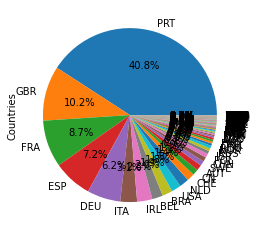

In [9]:
df["country"].value_counts().plot(kind='pie', label='Countries', autopct='%1.1f%%')

Seems as though about a third of the orders in our dataset are set for Portugal.
<br>
We can get the top 5 countries and use them as dummy variables with another 'other' variable instead of using 163 dummy variables.

In [10]:
def plot_top_n_countries(df, n):
    top_n_countries = list(df["country"].value_counts().head(n).index)
    series = pd.Series([country if country in top_n_countries else 'OTHER' for country in df["country"]])
    series.value_counts().plot(kind='pie', title=f'Top {n} Countries', autopct='%1.1f%%', label='')
    text = f"{series[series == 'OTHER'].value_counts().sum() * 100 / len(series)}% of countries labeled 'OTHER'"
    plt.figtext(0.5, 0.01, text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()

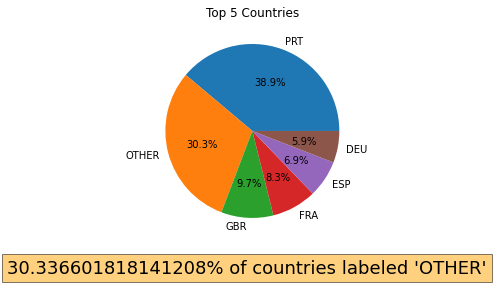

In [11]:
plot_top_n_countries(df, 5)


If 30% of 'other' countries is too much, we can take the top 10 or 15 countries, and then their distribution will be:

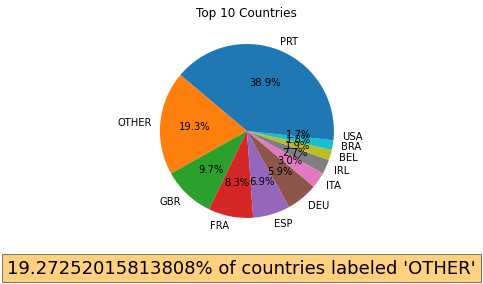

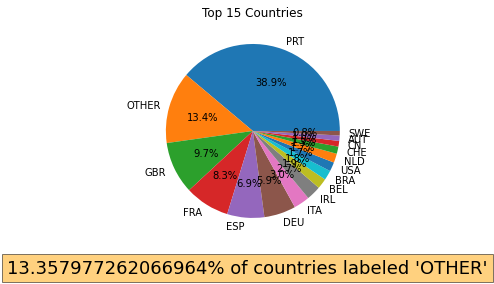

In [12]:
plot_top_n_countries(df, 10)
plot_top_n_countries(df, 15)

Let's try to see all the different countries so we can start mapping them by different parameters (continent, GDP score etc.)

In [13]:
# It seems that CN and CHN both represent China in their ISO codes, so we can unite them
merged_df.loc[merged_df["country"] == "CN", "country"] = "CHN"

In [14]:
merged_df["country"].unique()

array(['PRT', 'ESP', 'DEU', 'GBR', 'BRA', 'AGO', nan, 'ISR', 'FRA', 'TUR',
       'ITA', 'CHN', 'HUN', 'IRL', 'EST', 'USA', 'POL', 'NOR', 'AUT',
       'NLD', 'CIV', 'DNK', 'AUS', 'RUS', 'BEL', 'CZE', 'CMR', 'CHE',
       'MOZ', 'IDN', 'FIN', 'ROU', 'TJK', 'SWE', 'LUX', 'HRV', 'QAT',
       'TUN', 'GRC', 'LBN', 'KOR', 'LKA', 'MAR', 'TWN', 'ZAF', 'IND',
       'DZA', 'BGR', 'JPN', 'ARE', 'IRN', 'CYP', 'STP', 'MEX', 'SVK',
       'BLR', 'SRB', 'EGY', 'GHA', 'NZL', 'PRI', 'ECU', 'THA', 'ARG',
       'PHL', 'JOR', 'LTU', 'COL', 'URY', 'ISL', 'MAC', 'MKD', 'UKR',
       'SVN', 'ALB', 'SAU', 'KWT', 'SEN', 'SGP', 'AND', 'KAZ', 'GEO',
       'OMN', 'MDV', 'AZE', 'PER', 'DOM', 'NGA', 'ASM', 'CHL', 'CAF',
       'MYS', 'CRI', 'PAK', 'VEN', 'BHR', 'KEN', 'CPV', 'JEY', 'LVA',
       'GLP', 'MUS', 'MCO', 'MNE', 'HKG', 'BGD', 'CUB', 'GIB', 'BRB',
       'IRQ', 'GNB', 'PAN', 'SUR', 'LAO', 'FRO', 'BFA', 'MLT', 'PLW',
       'IMN', 'VNM', 'BOL', 'LCA', 'ARM', 'GAB', 'TGO', 'TZA', 'PRY',
       'GTM', '

In [15]:
continents = {
    "west-europe": ["PRT", "ESP", "DEU", "GBR", "FRA", "ITA", "IRL", "NOR", "AUT", "NLD", "DNK", "BEL",
                    "CHE", "FIN", "SWE", "LUX", "GRC", "CYP", "ISL", "SVN", "AND", "JEY", "MCO", "GIB",
                    "SMR", "LIE", "GGY"],
    "east-europe": ["HUN", "EST", "POL", "CZE", "ROU", "HRV", "BGR", "SVK", "BLR", "SRB", "LTU", "MKD",
                    "UKR", "ALB", "GEO", "AZE", "LVA", "MNE", "MLT", "ARM", "BIH"],
    "south-america": ["BRA", "MEX", "PRI", "ECU", "ARG", "COL", "URY", "PER", "DOM", "CHL", "CRI", "VEN",
                      "GLP", "CUB", "BRB", "PAN", "SUR", "BOL", "LCA", "PRY", "GTM", "ABW", "NIC", "JAM",
                      "GUY", "HND", "VGB", "KNA"],
    "africa": ["AGO", "CIV", "CMR", "MOZ", "TUN", "MAR", "ZAF", "DZA", "STP", "EGY", "GHA", "SEN", "NGA",
               "CAF", "KEN", "CPV", "MUS", "GNB", "BFA", "GAB", "TGO", "TZA", "ZMB", "LBY", "MRT", "SYC",
               "UGA", "MDG", "MWI", "BEN", "BDI", "NAM", "ZWE", "SLE", "BWA", "SDN"],
    "middle-east": ["ISR", "TUR", "QAT", "LBN", "ARE", "IRN", "JOR", "SAU", "KWT", "OMN", "BHR", "IRQ",
                    "SYR"],
    "asia": ["CHN", "RUS", "TJK", "MAC", "KAZ", "HKG"],
    "east-asia": ["KOR", "JPN", "KHM"],
    "south-asia": ["IDN", "LKA", "TWN", "IND", "THA", "PHL", "SGP", "MDV", "MYS", "PAK", "BGD", "LAO", "VNM"],
    "north-america": ["USA"],
    "australia": ["AUS", "NZL", "FJI"],
    "other": ["ASM", "FRO", "PLW", "IMN", "ATF", "MYT", "PYF", "COM", "ATA", "UMI", "TMP", np.nan]
}

country_to_continent = {}
for continent in continents.keys():
    country_to_continent.update({country: continent for country in continents[continent]})

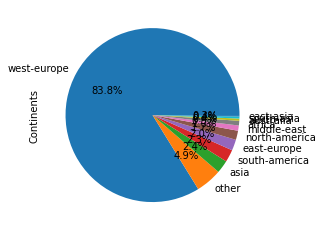

In [16]:
merged_df["continent"] = [country_to_continent[country] for country in merged_df["country"]]
merged_df["continent"].value_counts().plot(kind='pie', label='Continents', autopct='%1.1f%%')
plt.show()

In [17]:
seasons_north = {
    "January": "Winter",
    "February": "Winter",
    "March": "Spring",
    "April": "Spring",
    "May": "Spring",
    "June": "Summer",
    "July": "Summer",
    "August": "Summer",
    "September": "Fall",
    "October": "Fall",
    "November": "Fall",
    "December": "Winter"
}

seasons_south = {
    "January": "Summer",
    "February": "Summer",
    "March": "Fall",
    "April": "Fall",
    "May": "Fall",
    "June": "Winter",
    "July": "Winter",
    "August": "Winter",
    "September": "Spring",
    "October": "Spring",
    "November": "Spring",
    "December": "Summer"
}

southern_hemisphere = ["south-america", "africa", "south-asia", "australia"]

def label_season(row):
    if row["continent"] in southern_hemisphere:
        return seasons_south.get(row["order_month"], np.nan)
    return seasons_north.get(row["order_month"], np.nan)

merged_df["season"] = merged_df.apply(label_season, axis=1)

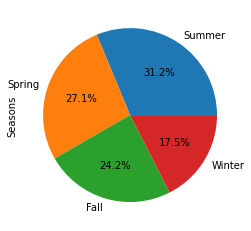

In [18]:
merged_df["season"].value_counts().plot(kind='pie', label='Seasons', autopct='%1.1f%%')
plt.show()

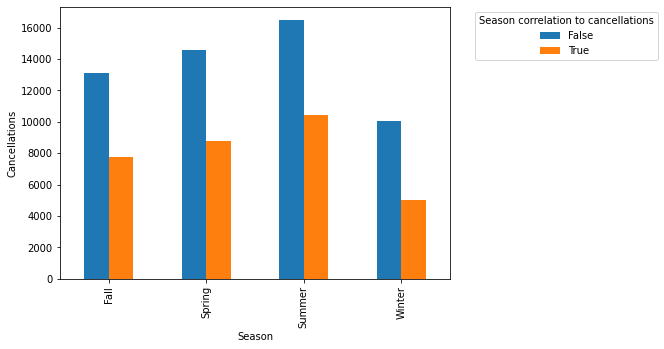

In [19]:
dfu = merged_df.groupby(['season']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='Season correlation to cancellations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Season')
plt.ylabel('Cancellations')
plt.show()

Now, let's see how the rest of the categorical features are distributed

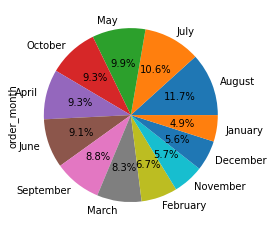

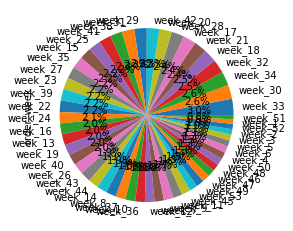

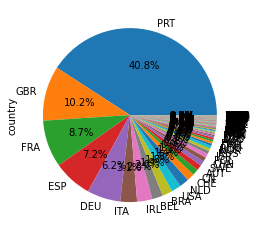

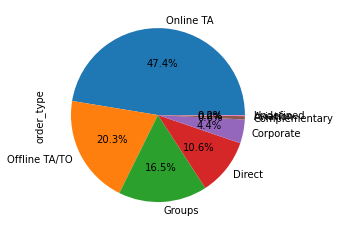

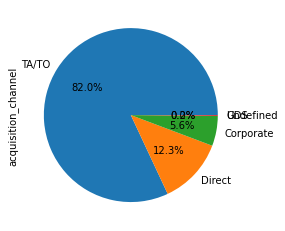

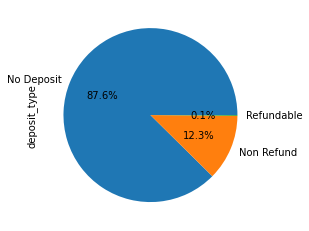

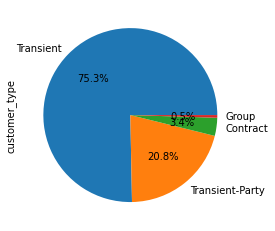

In [20]:
for category in categorical_cols:
    plt.plot()
    df[category].value_counts().plot(kind='pie', label=category, autopct='%1.1f%%')
    plt.show()

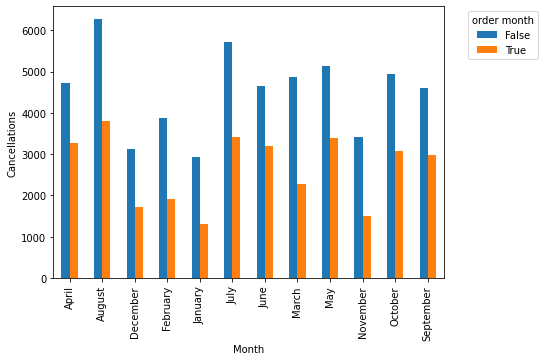

In [21]:
dfu = merged_df.groupby(['order_month']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='order month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Month')
plt.ylabel('Cancellations')
plt.show()

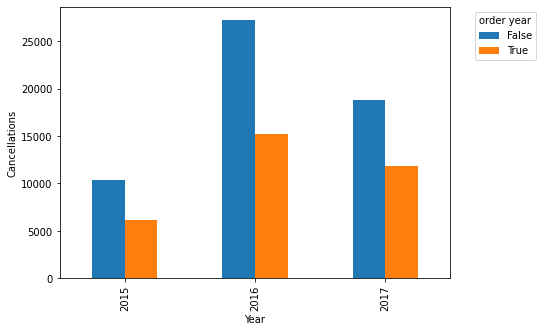

In [22]:
dfu = merged_df.groupby(['order_year']).cancelation.value_counts().unstack()
dfu.plot.bar(figsize=(7, 5))
plt.legend(title='order year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Cancellations')
plt.show()


Let's see how the different numerical variables are distributed

array([[<AxesSubplot:title={'center':'time_until_order'}>,
        <AxesSubplot:title={'center':'order_year'}>,
        <AxesSubplot:title={'center':'order_day_of_month'}>,
        <AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'babies'}>,
        <AxesSubplot:title={'center':'prev_canceled'}>,
        <AxesSubplot:title={'center':'prev_not_canceled'}>,
        <AxesSubplot:title={'center':'changes'}>,
        <AxesSubplot:title={'center':'agent'}>],
       [<AxesSubplot:title={'center':'company'}>,
        <AxesSubplot:title={'center':'adr'}>,
        <AxesSubplot:title={'center':'anon_feat_0'}>,
        <AxesSubplot:title={'center':'anon_feat_1'}>,
        <AxesSubplot:title={'center':'anon_feat_2'}>],
       [<AxesSubplot:title={'center':'anon_feat_3'}>,
        <AxesSubplot:title={'center':'anon_feat_4'}>,
        <AxesSubplot:title={'center':'anon_feat_5'}>,
        <AxesSubplot:title={'center':'ano

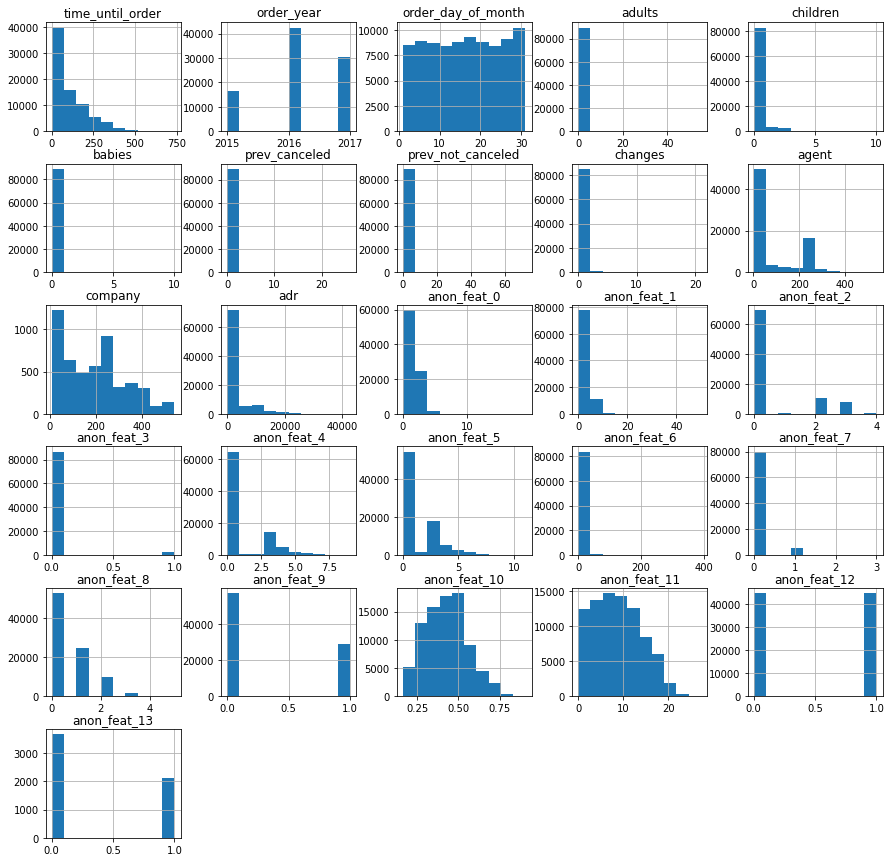

In [23]:
df.hist(figsize=(15, 15))

We can see that there are a some features that have a single value for almost all samples, and another value for a few others.
These features are: children, babies, prev_canceled, prev_not_canceled, changes, anon_feat_3, anon_feat_6 and anon_feat_7.

In [24]:
zero_values = pd.DataFrame(columns=["name", "zero_count", "non_zero_count"])
single_variable_columns = ["children", "babies", "prev_canceled", "prev_not_canceled", "changes",
                           "anon_feat_3", "anon_feat_6", "anon_feat_7"]
for col in single_variable_columns:
    zero_values.loc[single_variable_columns.index(col)] = [col, (df[col] == 0).sum(), (df[col] != 0).sum()]

zero_values

,name,zero_count,non_zero_count
0,children,83080,6462
1,babies,88854,688
2,prev_canceled,84677,4865
3,prev_not_canceled,86832,2710
4,changes,72965,16577
5,anon_feat_3,86656,2886
6,anon_feat_6,82621,6921
7,anon_feat_7,79976,9566


It does seem like all these features have around 90% of zeros, and up to 10% of non-zero values.
Let's remove the variables in which the non-zero count is less than 5%

In [25]:
cols_to_remove = zero_values[zero_values["non_zero_count"] < df.shape[0] * 0.05]["name"]
print(f"Removing the following columns: {', '.join(cols_to_remove)}.")

df = df.drop(columns=cols_to_remove)

Removing the following columns: babies, prev_not_canceled, anon_feat_3.


The rest of the features can be turned into boolean features which differentiate zeros from non-zeros.

In [26]:
cols_to_change = zero_values[(~zero_values["name"].isin(cols_to_remove))]["name"]
for col in cols_to_change:
    df.loc[df[col] != 0, col] = 1

<AxesSubplot:>

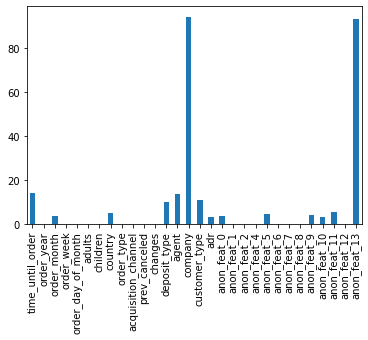

In [27]:
(df.isnull().sum() * 100 / len(df)).plot.bar()

More than 50% of samples have null values for "company" and "anon_feat_13".

Let's start with preprocessing our data

In [28]:
processed_df = df.copy()
# Let's convert categorical columns to numerical ones
months = [np.nan, "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
processed_df["order_month"] = [months.index(month) for month in processed_df["order_month"]]
processed_df["order_week"] = [int(week.replace("week_", "")) for week in processed_df["order_week"]]

# We can turn deposit_exists into a boolean variable because most values are "No Deposit"
processed_df["deposit_exists"] = [int(deposit_type != "No Deposit") for deposit_type in processed_df["deposit_type"]]
processed_df = processed_df.drop(columns=["deposit_type"])

# Let's normalize order_year
processed_df["order_year"] = processed_df["order_year"] - 2015

In [29]:
# Let's say we'll keep the top 10 countries
top_n_countries = list(df["country"].value_counts().head(10).index)
processed_df["country"] = [country if country in top_n_countries else "OTHER" for country in processed_df["country"]]


In [30]:
# Let's mark Undefined values as NaN
processed_df.loc[processed_df["acquisition_channel"] == "Undefined", "acquisition_channel"] = np.nan
processed_df.loc[processed_df["order_type"] == "Undefined", "order_type"] = np.nan

In [31]:
# This function creates dummy features for a given list of columns
def dummify(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col, dummy_na=False)
        df = df.drop(col, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [32]:
processed_df = dummify(processed_df, ["country", "order_type", "acquisition_channel", "customer_type"])

Let's look at the correlation between all features as of now.
We can plot a heatmap, but since there are so many features it would look distorted. Here's a solution using a table.

In [33]:
corr_matrix = processed_df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
sol[sol > 0.8]

time_until_order   anon_feat_11                  0.959980
order_month        order_week                    0.901563
order_type_Direct  acquisition_channel_Direct    0.891016
anon_feat_4        anon_feat_5                   0.814067
dtype: float64

Seems as there's a really high correlation between time_until_order and anon_feat_11. <br />
It also looks like there's a high correlation between order_month and order_week,
order_type_Direct and acquisition_channel_Direct,
anon_feat_4 and anon_feat_5. <br />
Let's remove one of each pair.

In [34]:
processed_df = processed_df.drop(columns=["anon_feat_11", "order_week", "acquisition_channel_Direct", "anon_feat_5"])

Even though the following heatmap is overloaded with variables, we can see that there are no features
with unusual levels of correlation.

<AxesSubplot:>

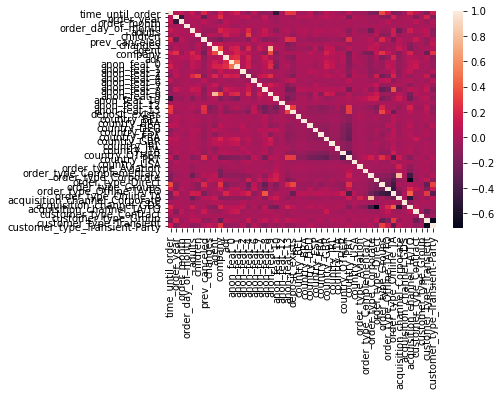

In [35]:
sns.heatmap(processed_df.corr(),
            xticklabels=processed_df.corr().columns,
            yticklabels=processed_df.corr().columns)

Let's detect outliers in our dataset

In [36]:
print("\n".join([f"{col}: {processed_df[col].dtype}" for col in processed_df.columns]))

time_until_order: float64
order_year: int64
order_month: int64
order_day_of_month: int64
adults: int64
children: float64
prev_canceled: int64
changes: float64
agent: float64
company: float64
adr: float64
anon_feat_0: float64
anon_feat_1: int64
anon_feat_2: int64
anon_feat_4: int64
anon_feat_6: float64
anon_feat_7: float64
anon_feat_8: int64
anon_feat_9: float64
anon_feat_10: float64
anon_feat_12: int64
anon_feat_13: float64
deposit_exists: int64
country_BEL: uint8
country_BRA: uint8
country_DEU: uint8
country_ESP: uint8
country_FRA: uint8
country_GBR: uint8
country_IRL: uint8
country_ITA: uint8
country_OTHER: uint8
country_PRT: uint8
country_USA: uint8
order_type_Aviation: uint8
order_type_Complementary: uint8
order_type_Corporate: uint8
order_type_Direct: uint8
order_type_Groups: uint8
order_type_Offline TA/TO: uint8
order_type_Online TA: uint8
acquisition_channel_Corporate: uint8
acquisition_channel_GDS: uint8
acquisition_channel_TA/TO: uint8
customer_type_Contract: uint8
customer_ty

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explic

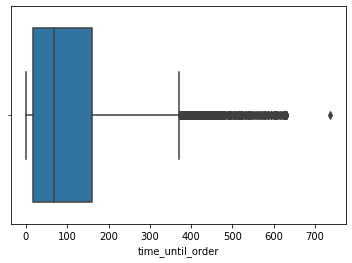

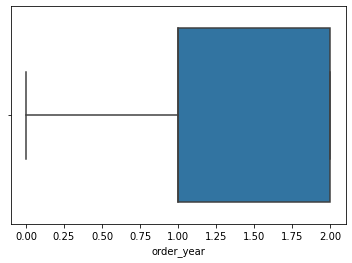

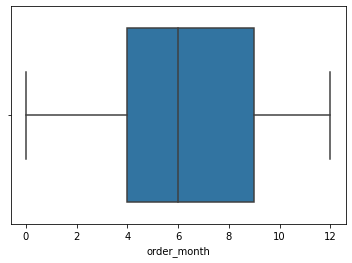

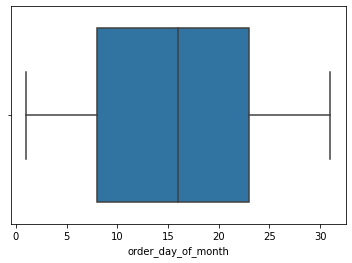

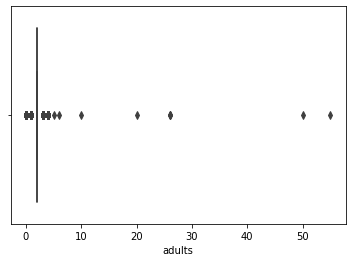

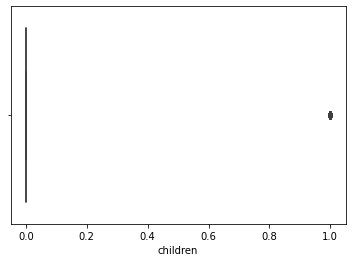

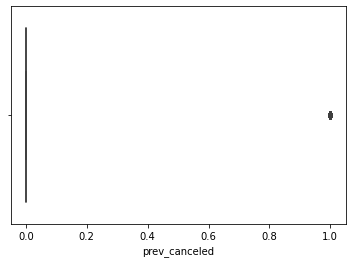

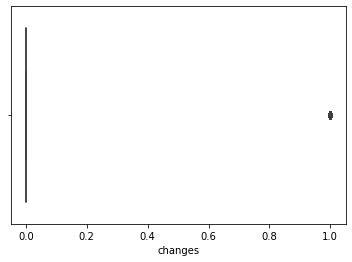

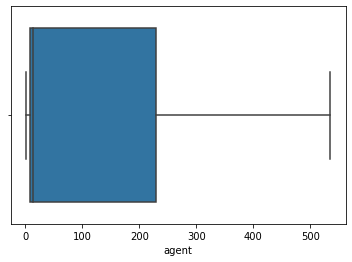

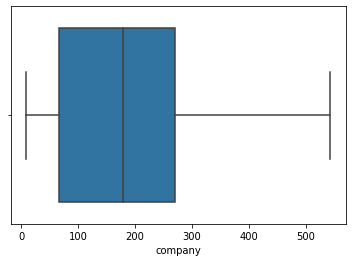

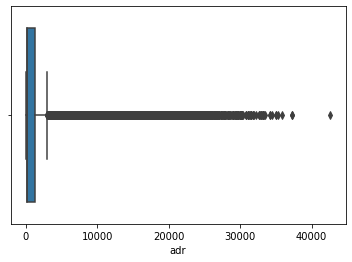

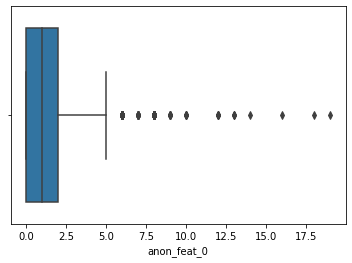

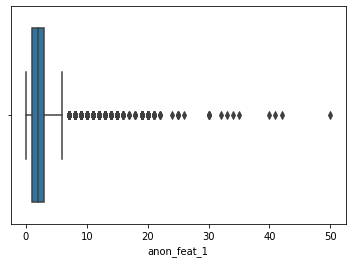

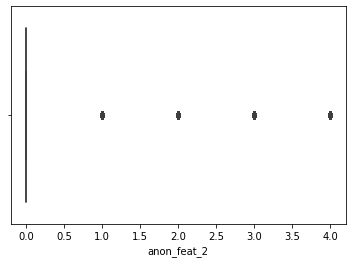

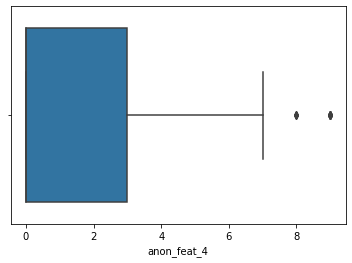

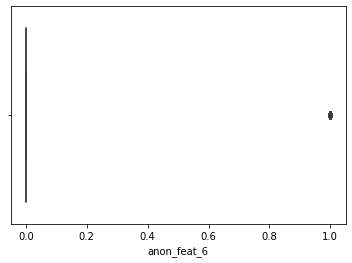

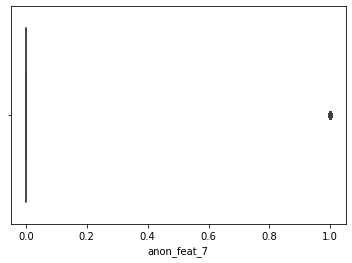

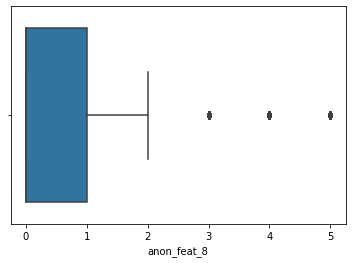

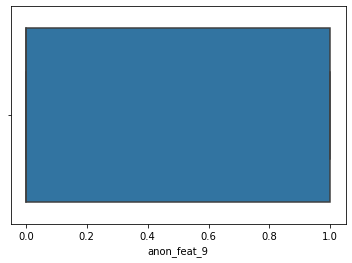

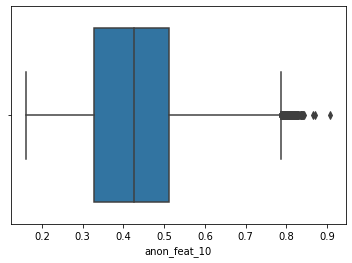

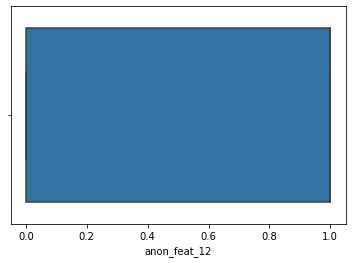

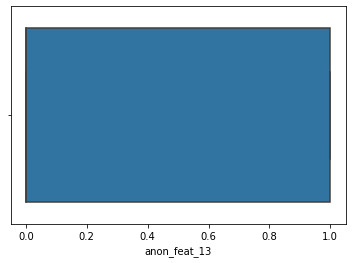

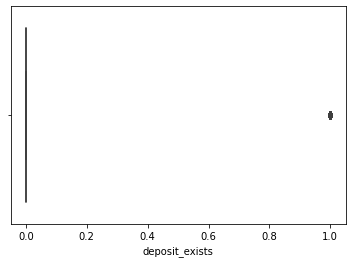

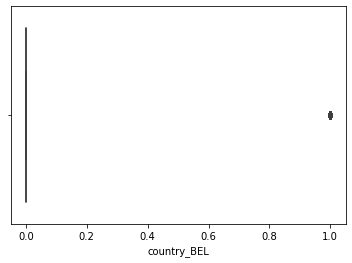

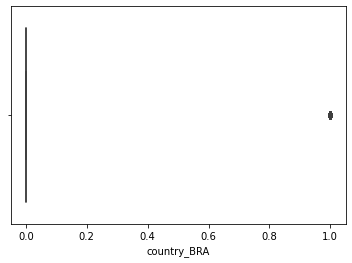

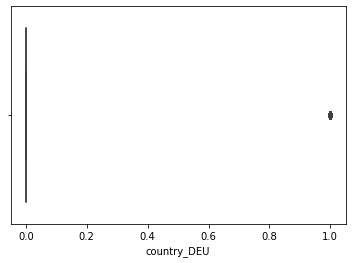

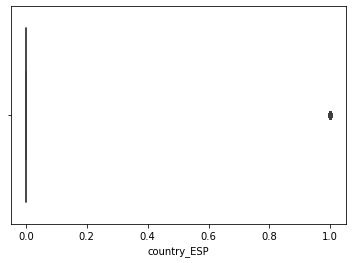

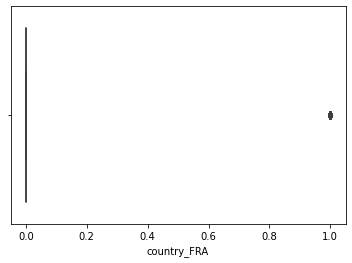

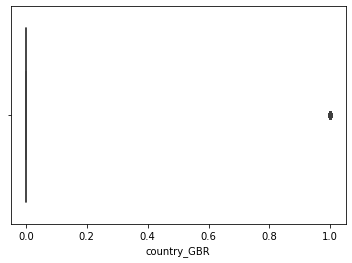

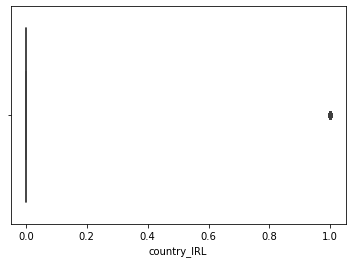

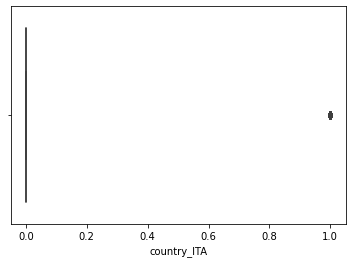

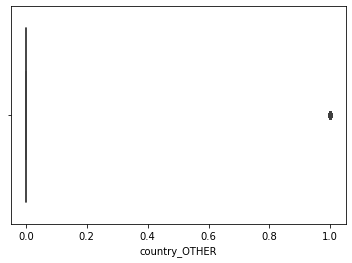

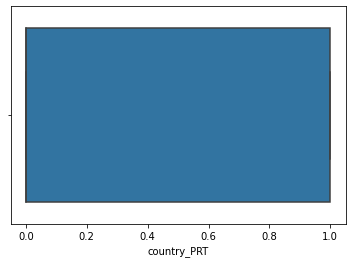

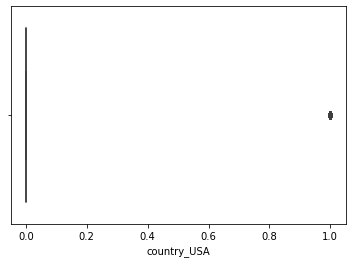

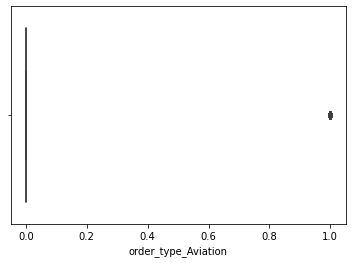

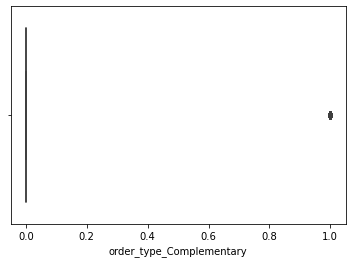

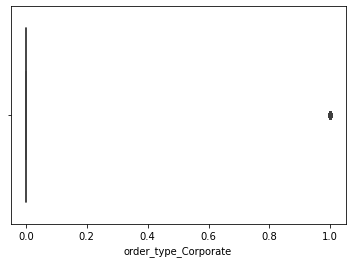

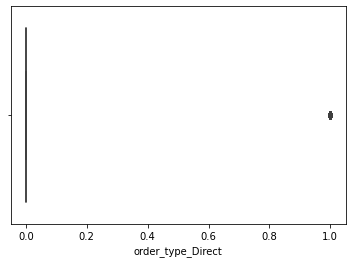

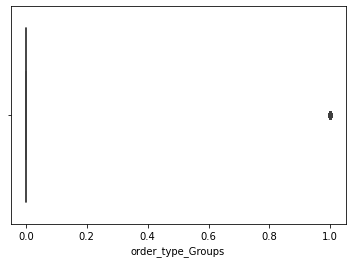

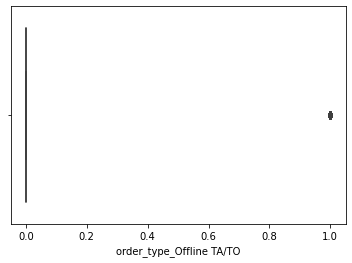

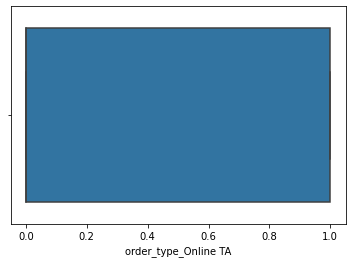

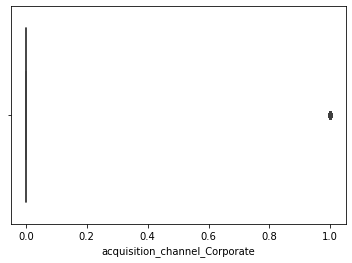

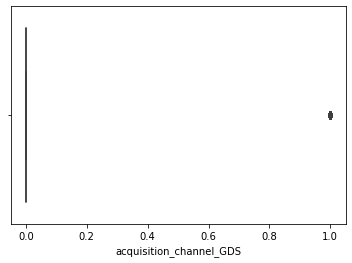

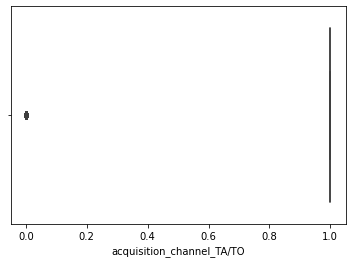

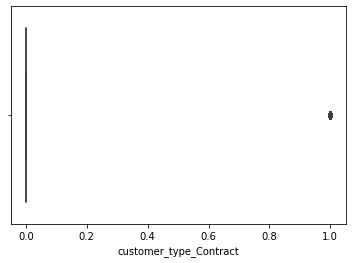

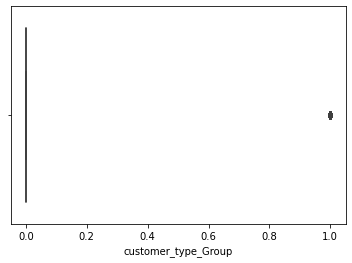

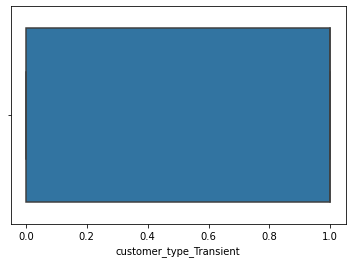

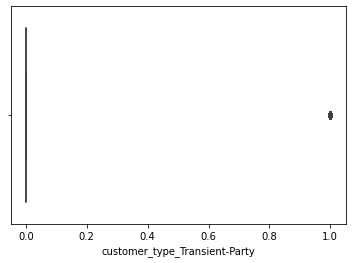

In [37]:
for column in processed_df.columns:
    sns.boxplot(processed_df[column])
    plt.show()

The following variables seem to have outliers:<br>
time_until_order<br>
anon_feat_0<br>
anon_feat_4<br>
anon_feat_5<br>
anon_feat_8<br>
anon_feat_10

In [39]:
# outlier_cols = ["time_until_order", "anon_feat_0", "anon_feat_4", "anon_feat_5", "anon_feat_8", "anon_feat_11"]
# outliers = []
# for col in outlier_cols:
#     outliers.append(processed_df[processed_df[col] > processed_df[col].mean() + 3 * processed_df[col].std()])
#
# outliers = pd.concat(outliers)
# processed_df = processed_df.drop(outliers.index)
# processed_labels = labels.drop(outliers.index)

In [40]:
# import seaborn as sns
# for column in ["time_until_order", "anon_feat_0", "anon_feat_4", "anon_feat_5", "anon_feat_8", "anon_feat_11"]:
#     sns.boxplot(processed_df[column])
#     plt.show()

Now we don't have any categorical features in our dataset.
Next step is to deal with missing values.

In [41]:
# Let's replace all missing values with their 5 nearest neighbors' average values
# imp_knn = KNNImputer()
# imp_knn.fit(processed_df)
#
# processed_df = pd.DataFrame(data=imp_knn.transform(processed_df), columns=processed_df.columns)

Let's normalize some of our features.
<Insert reason why we didn't normalize the features we didn't>
anon_feat_3 and anon_feat_12 are boolean

In [42]:
# cols_to_norm = ["order_year", "order_month", "order_week", "order_day_of_month", "anon_feat_0", "anon_feat_1",
#                 "anon_feat_2", "anon_feat_4", "anon_feat_5", "anon_feat_6", "anon_feat_7", "anon_feat_8", "anon_feat_9",
#                 "anon_feat_10", "anon_feat_11"]
# processed_df[cols_to_norm] = StandardScaler().fit_transform(processed_df[cols_to_norm])

In [43]:
# processed_df

We still have 53 features, which is kind of a lot.
Let's use PCA to remove some features and keep 2 features for our models.

In [44]:
# pca = PCA(n_components=2, whiten=True)
# pca_data = pca.fit_transform(processed_df)
# pca_df = pd.DataFrame(data=pca_data, columns=["principal component 1", "principal component 2"])
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [45]:
# plt.scatter(pca_data[:,0], pca_data[:,1], c = processed_labels["cancelation"])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

OK... That doesn't look good.<br>
Let's try selecting the top 10 features

Here's a function that will preprocess an entire dataframe, to make preprocessing easy for both train and test samples

In [46]:
def preprocess(df, top_n_countries=None, outlier_cols=None, labels=None):
    # Remove columns with a lot of NaN values
    processed_df = df.drop(columns=["company", "anon_feat_13"])
    processed_labels = labels
    # Let's convert categorical columns to numerical ones
    months = [np.nan, "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    processed_df["order_month"] = [months.index(month) for month in processed_df["order_month"]]
    processed_df["order_week"] = [int(week.replace("week_", "")) for week in processed_df["order_week"]]
    processed_df["deposit_exists"] = [deposit_type != "No Deposit" for deposit_type in processed_df["deposit_type"]]
    processed_df = processed_df.drop(columns=["deposit_type"])
    # Let's keep the countries that are specified by top_n_countries
    if top_n_countries:
        processed_df["country"] = [country if country in top_n_countries else "OTHER" for country in processed_df["country"]]
    # Let's mark Undefined values as NaN
    processed_df.loc[processed_df["acquisition_channel"] == "Undefined", "acquisition_channel"] = np.nan
    processed_df.loc[processed_df["order_type"] == "Undefined", "order_type"] = np.nan
    processed_df = dummify(processed_df, ["country", "order_type", "acquisition_channel", "customer_type"])

    if outlier_cols:
        outliers = []
        for col in outlier_cols:
            outliers.append(processed_df[processed_df[col] > processed_df[col].mean() + 3 * processed_df[col].std()])

        outliers = pd.concat(outliers)
        processed_df = processed_df.drop(outliers.index)
        processed_labels = labels.drop(outliers.index)

    # Let's replace all missing values with their 5 nearest neighbors' average values
    imp_knn = KNNImputer()
    imp_knn.fit(processed_df)

    processed_df = pd.DataFrame(data=imp_knn.transform(processed_df), columns=processed_df.columns)
    cols_to_norm = ["order_year", "order_month", "order_week", "order_day_of_month", "anon_feat_0", "anon_feat_1",
                "anon_feat_2", "anon_feat_4", "anon_feat_5", "anon_feat_6", "anon_feat_7", "anon_feat_8", "anon_feat_9",
                "anon_feat_10", "anon_feat_11"]
    processed_df[cols_to_norm] = StandardScaler().fit_transform(processed_df[cols_to_norm])

    return processed_df, processed_labels

In [47]:
def pca(df, n):
    pca = PCA(n_components=n, whiten=True)
    pca_data = pca.fit_transform(df)
    pca_df = pd.DataFrame(data=pca_data)
    return pca_df

In [48]:
# top_n_countries = list(df["country"].value_counts().head(10).index)
outlier_cols = ["time_until_order", "anon_feat_0", "anon_feat_4", "anon_feat_5", "anon_feat_8", "anon_feat_11"]
processed_df, processed_labels = preprocess(df, top_n_countries=None,
                                            outlier_cols=[], labels=labels)

<AxesSubplot:xlabel='0', ylabel='1'>

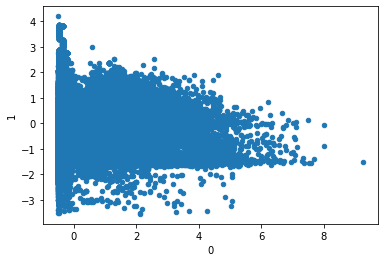

In [53]:
pca_df = pca(processed_df, 2)
pca_df.plot.scatter(x=pca_df.columns[0], y=pca_df.columns[1])

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings('ignore')

Cs = [10**p for p in range(-10, 0)]
pca_n = list(range(2, len(processed_df.columns)))
scores = {}
for C in Cs:
    for n in pca_n:
        pca_df = pca(processed_df, n)
        clf = LogisticRegression(random_state=0, solver='saga', C=C)
        score = cross_val_score(clf, pca_df, processed_labels)
        scores[(C,n)] = score

In [ ]:
scores = {key: value.mean() for key, value in scores.items()}

In [ ]:
max_score = max(scores.values())
best_c, best_n = [key for key, value in scores.items() if value == max_score][0]
print(f"C={best_c}, PCA_n={best_n}, Score={max_score}")